In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
os.chdir('drive/My Drive/model_train/03 house-prices')

In [3]:
!pip install pandas_profiling

#### 导入包

In [0]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats
from scipy.stats import skew, boxcox_normmax
from scipy.special import boxcox1p
import pandas_profiling
from datetime import datetime

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LassoCV, ElasticNetCV, RidgeCV
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from mlxtend.regressor import StackingCVRegressor

In [0]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

#### EDA数据探索性分析

In [6]:
print(train.shape)    # (1460, 81)
print(test.shape)     # (1459, 80)

(1460, 81)

In [0]:
train_dty = train.dtypes
train_obj_names = list(train_dty[train_dty=='object'].index)    # 43
train_int_names = list(train_dty[train_dty=='int64'].index)    # 35-2   
train_flt_names = list(train_dty[train_dty=='float64'].index)   # 3

train_int_names.remove('Id')
train_int_names.remove('SalePrice')

##### 缺失值

Electrical         1
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
BsmtExposure      38
BsmtFinType2      38
GarageCond        81
GarageQual        81
GarageFinish      81
GarageType        81
GarageYrBlt       81
LotFrontage      259
FireplaceQu      690
Fence           1179
Alley           1369
MiscFeature     1406
PoolQC          1453
dtype: int64


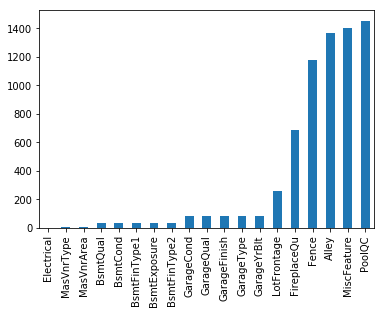

In [8]:
%matplotlib inline
missing = train.isnull().sum()
missing = missing[missing>0]
missing.sort_values(inplace=True)
print(missing)
missing.plot.bar()
plt.show()
# 19个含有缺失值的feature，其中有5个feature缺失值大于50%

In [9]:
train[train['GarageCond'].isnull()].head()
# 发现GarageCond\GarageQual\GarageFinish\GarageType四个是一起的

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
39  40          90       RL         65.0     6040   Pave   NaN      Reg   
48  49         190       RM         33.0     4456   Pave   NaN      Reg   
78  79          90       RL         72.0    10778   Pave   NaN      Reg   
88  89          50  C (all)        105.0     8470   Pave   NaN      IR1   
89  90          20       RL         60.0     8070   Pave   NaN      Reg   

   LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
39         Lvl    AllPub    Inside       Gtl      Edwards       Norm   
48         Lvl    AllPub    Inside       Gtl      OldTown       Norm   
78         Lvl    AllPub    Inside       Gtl       Sawyer       Norm   
88         Lvl    AllPub    Corner       Gtl       IDOTRR      Feedr   
89         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   

   Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
39       Norm   Duplex     1Story            4            5       1955   
48       Norm   2fmCon     2Story            4            5       1920   
78       Norm   Duplex     1Story            4            5       1968   
88      Feedr     1Fam     1.5Fin            3            2       1915   
89       Norm     1Fam     1Story            4            5       1994   

    YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
39          1955     Gable  CompShg     AsbShng     Plywood       None   
48          2008     Gable  CompShg     MetalSd     MetalSd       None   
78          1968       Hip  CompShg     HdBoard     HdBoard       None   
88          1982       Hip  CompShg     Plywood     Plywood       None   
89          1995     Gable  CompShg     VinylSd     VinylSd       None   

    MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
39         0.0        TA        TA      PConc      NaN      NaN          NaN   
48         0.0        TA        TA     BrkTil       TA       TA           No   
78         0.0        TA        TA     CBlock       TA       TA           No   
88         0.0        Fa        Fa     CBlock       TA       Fa           No   
89         0.0        TA        TA      PConc       Gd       TA           No   

   BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
39          NaN           0          NaN           0          0            0   
48          Unf           0          Unf           0        736          736   
78          Unf           0          Unf           0       1768         1768   
88          Unf           0          Unf           0       1013         1013   
89          GLQ         588          Unf           0        402          990   

   Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
39    GasA        TA          N      FuseP      1152         0             0   
48    GasA        Gd          Y      SBrkr       736       716             0   
78    GasA        TA          N      SBrkr      1768         0             0   
88    GasA        TA          N      SBrkr      1013         0           513   
89    GasA        Ex          Y      SBrkr       990         0             0   

    GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
39       1152             0             0         2         0             2   
48       1452             0             0         2         0             2   
78       1768             0             0         2         0             4   
88       1526             0             0         1         0             2   
89        990             1             0         1         0             3   

    KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
39             2          Fa             6        Typ           0         NaN   
48             3          TA             8        Typ           0         NaN   
78             2          TA             8        Typ           0    

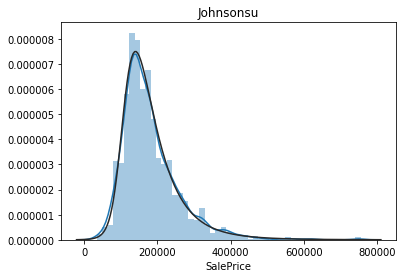

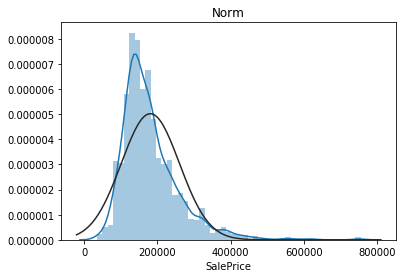

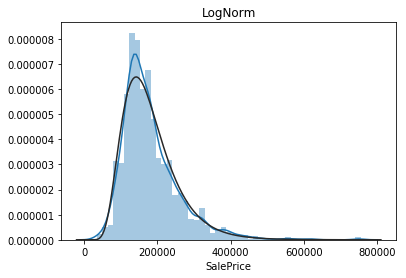

In [10]:
# 检验目标值是否服从正态分布
y = train['SalePrice']
plt.figure(1); plt.title('Johnsonsu');
sns.distplot(y, kde=True, fit=stats.johnsonsu)
## :kde：是否绘制高斯核密度图; 

plt.figure(2); plt.title('Norm')
sns.distplot(y, kde=True, fit=stats.norm)

plt.figure(3); plt.title('LogNorm')
sns.distplot(y, kde=True, fit=stats.lognorm)

# 显然目标值'SalePrice'不服从正态分布，因此在进行回归之前需要取对数，而拟合最好的是johnsonsu分布
#### 【问题：johnsonsu分布到底是什么分布？】 ####

##### pandas_profiling初步了解情况
pandas_profiling.ProfileReport()

In [11]:
pandas_profiling.ProfileReport(train)

##### 检测连续型feature是否具有正态分布

In [12]:
test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.01
## shapirpo专门做正态检验的模块，当样本数大于时，不再适合用其做正态分布，得到的p值可能不准确
normal = pd.DataFrame(train[list(train_int_names+train_flt_names)])
normal = normal.apply(test_normality)  # normal每列都为true，说明每个都拒绝了正态分布的假设
print(not normal.any())

# 所有数值型feature都不服从正态分布，所以都需要进行数值转换

False


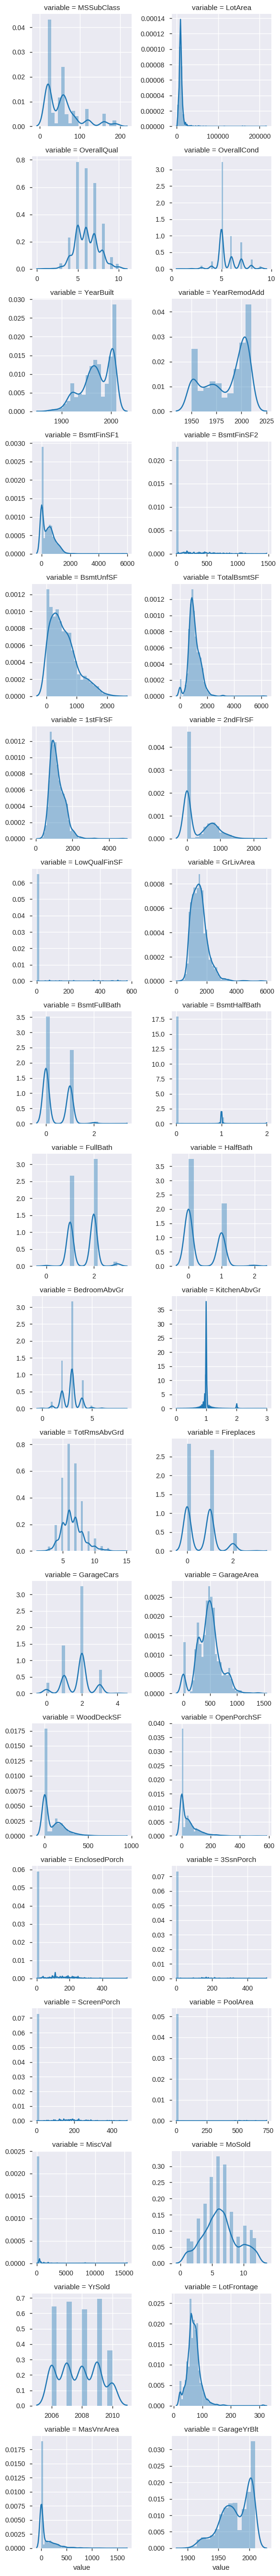

In [13]:
f = pd.melt(train, value_vars=list(train_int_names+train_flt_names))   # 有点类似于透视表，转为了两列数据
#### 【参考：https://www.cnblogs.com/xiaodongsuibi/p/10054736.html】 ####
g = sns.FacetGrid(f, col='variable', col_wrap=2, sharex=False, sharey=False)
g = g.map(sns.distplot, 'value')
plt.show()

# 由此进一步确定很多连续型变量应该做log变换

##### 处理类别型变量
用到了两种方法：

    1. 先画箱型图大致看一下，类间对y的影响区分度；
    2. 再用单因素方差分析得到p值取量化分析，并且通过ANOVA也能得到哪个变量间的差异对y的影响最大

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


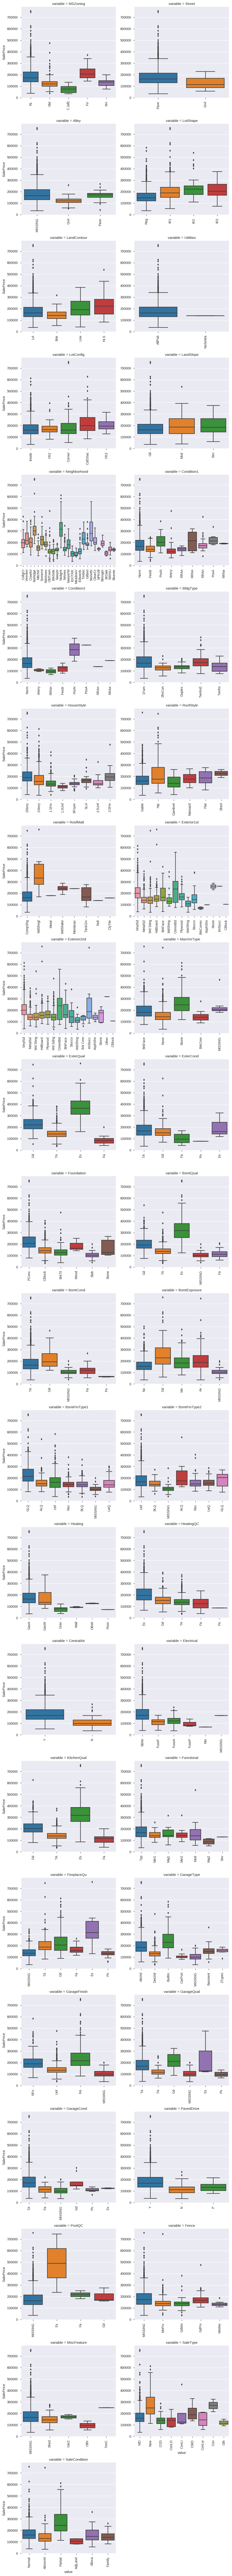

In [14]:
import seaborn
for c in train_obj_names:
    train[c] = train[c].astype('category')
    if train[c].isnull().any():
        train[c] = train[c].cat.add_categories('MISSING')
        train[c] = train[c].fillna('MISSING')

def boxplot(x, y, **kwargs):
    # import seaborn as sns
    sns = seaborn.boxplot(x=x, y=y)
    x = plt.xticks(rotation=90)

f = pd.melt(train, id_vars=['SalePrice'], value_vars=train_obj_names)
g = seaborn.FacetGrid(f, col='variable', col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(boxplot, 'value', 'SalePrice')
plt.show()

# 一些类别型变量对SalePrice有重要的影响，如Neighborhood, 拥有资产多少对其有重要影响

'\nHere is quick estimation of influence of categorical variable on SalePrice. For each variable SalePrices \nare partitioned to distinct sets based on category values. Then check with ANOVA test if sets have similar \ndistributions. If variable has minor impact then set means should be equal. Decreasing pval is sign of\nincreasing diversity in partition\n'

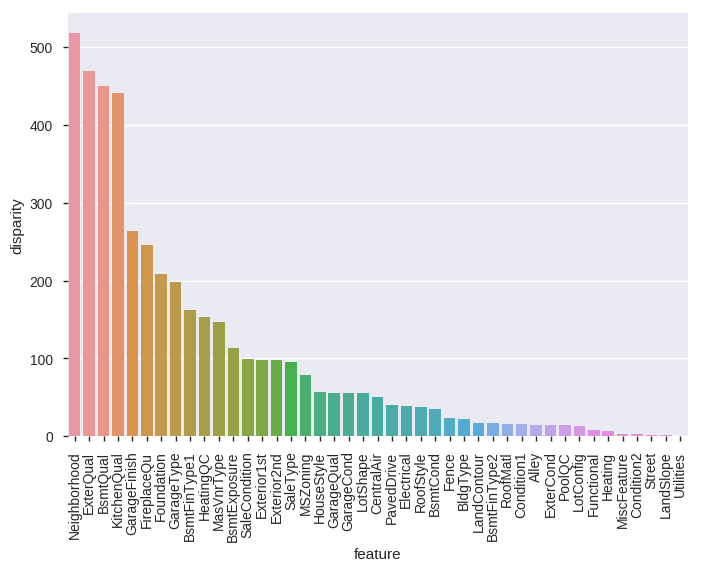

In [15]:
# 单因素方差分析，分析类间的差距
def anova(frame):
    anv = pd.DataFrame()
    anv['feature'] = train_obj_names    # 类别型特征的名字
#     print("anv['feature'] ",anv['feature'])
    pvals = []
    for c in train_obj_names:
        samples = []
        for cls in frame[c].unique():
            s = frame[frame[c] == cls]['SalePrice'].values
            samples.append(s)    # samples是列表，s是array，把每类的每一小种对应的saleprice添加进samples
        pval = stats.f_oneway(*samples)[1]    # p值
        pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

a = anova(train)
a['disparity'] = np.log(1./a['pval'].values)    # 类间差距越大，p值越小，进行一下变换，使其在图上显示是较明显
sns.barplot(data=a, x='feature', y='disparity')
x=plt.xticks(rotation=90)
#### 【参考：https://www.kaggle.com/dgawlik/house-prices-eda#Categorical-data】 ####
'''
Here is quick estimation of influence of categorical variable on SalePrice. For each variable SalePrices 
are partitioned to distinct sets based on category values. Then check with ANOVA test if sets have similar 
distributions. If variable has minor impact then set means should be equal. Decreasing pval is sign of
increasing diversity in partition
'''


In [16]:
a.head(5)

feature           pval   disparity
8   Neighborhood  1.558600e-225  517.637858
18     ExterQual  1.439551e-204  469.363028
21      BsmtQual  8.158548e-196  449.207612
30   KitchenQual  3.032213e-192  440.987045
34  GarageFinish  6.228747e-115  262.968110

In [17]:
# 对类别型特征进行编码，按照每一类数目的多少进行编码，该类数目最多则编码为1，依次类推
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        frame.loc[frame[feature]==cat, feature+'_E'] = o
        ## 该特征列的值等于cat时，将其赋值为对应的o值 ##

obj_encoded = []
for q in train_obj_names:
    encode(train, q)
    obj_encoded.append(q + '_E')
print(obj_encoded)

# 把类别型特征按照其子类数目SalePrice的高低进行编码，所以train的列数变多

['MSZoning_E', 'Street_E', 'Alley_E', 'LotShape_E', 'LandContour_E', 'Utilities_E', 'LotConfig_E', 'LandSlope_E', 'Neighborhood_E', 'Condition1_E', 'Condition2_E', 'BldgType_E', 'HouseStyle_E', 'RoofStyle_E', 'RoofMatl_E', 'Exterior1st_E', 'Exterior2nd_E', 'MasVnrType_E', 'ExterQual_E', 'ExterCond_E', 'Foundation_E', 'BsmtQual_E', 'BsmtCond_E', 'BsmtExposure_E', 'BsmtFinType1_E', 'BsmtFinType2_E', 'Heating_E', 'HeatingQC_E', 'CentralAir_E', 'Electrical_E', 'KitchenQual_E', 'Functional_E', 'FireplaceQu_E', 'GarageType_E', 'GarageFinish_E', 'GarageQual_E', 'GarageCond_E', 'PavedDrive_E', 'PoolQC_E', 'Fence_E', 'MiscFeature_E', 'SaleType_E', 'SaleCondition_E']


In [18]:
train.shape

(1460, 124)

##### 相关性

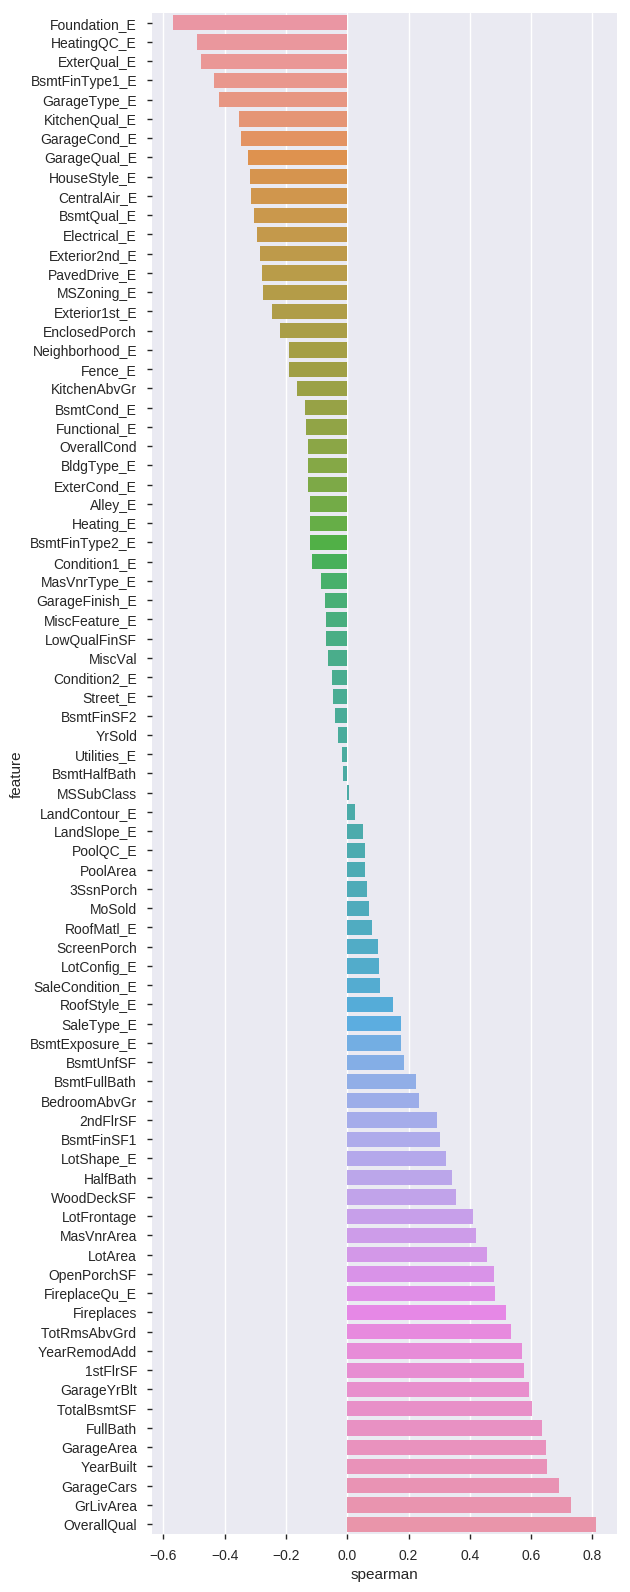

In [19]:
def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['SalePrice'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6,0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    return spr

features = list(train_int_names) + list(train_flt_names) + list(obj_encoded)
spr = spearman(train, features)

# 可以看出各个feature与SalePrice的相关性，【但是这个结果和别人做的不太一样】

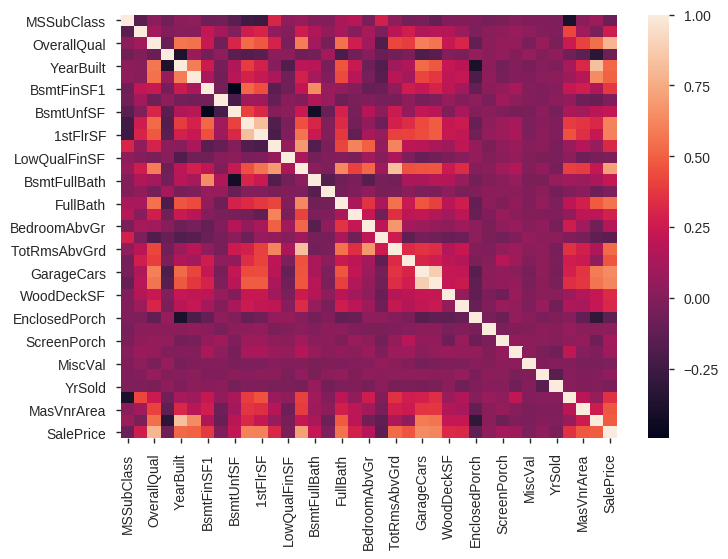

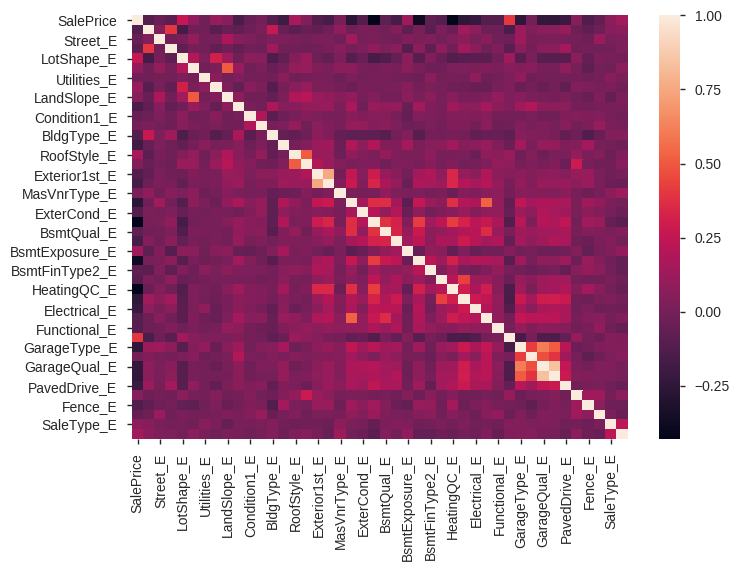

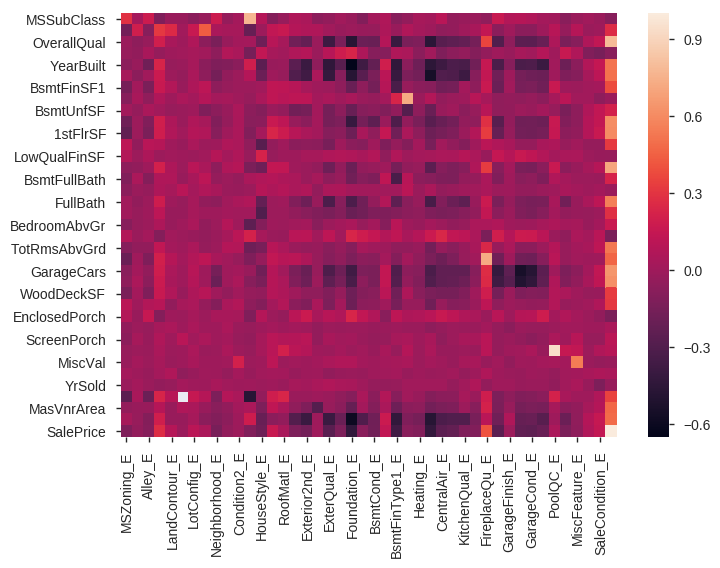

In [20]:
# 用热力图进行分析

## 先分析连续型变量间的相关性
plt.figure(1)
corr = train[train_int_names + train_flt_names + ['SalePrice']].corr()
sns.heatmap(corr)

## 在分析类别型变量的相关性
plt.figure(2)
corr2 = train[['SalePrice']+obj_encoded].corr()
sns.heatmap(corr2)

## 分析数值型和类别型变量间的相关性
plt.figure(3)
corr = pd.DataFrame(np.zeros([len(train_int_names+train_flt_names)+1, len(obj_encoded)+1]), index=train_int_names+train_flt_names+['SalePrice'], columns=obj_encoded+['SalePrice'])
for q1 in train_int_names+train_flt_names+['SalePrice']:
    for q2 in obj_encoded+['SalePrice']:
        corr.loc[q1, q2] = train[q1].corr(train[q2])
sns.heatmap(corr)

# 

In [21]:
train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street    Alley LotShape  \
0   1          60       RL         65.0     8450   Pave  MISSING      Reg   
1   2          20       RL         80.0     9600   Pave  MISSING      Reg   
2   3          60       RL         68.0    11250   Pave  MISSING      IR1   
3   4          70       RL         60.0     9550   Pave  MISSING      IR1   
4   5          60       RL         84.0    14260   Pave  MISSING      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ         706          Unf           0        150          856   
1          ALQ         978          Unf           0        284         1262   
2          GLQ         486          Unf           0        434          920   
3          ALQ         216          Unf           0        540          756   
4          GLQ         655          Unf           0        490         1145   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr       856       854             0   
1    GasA        Ex          Y      SBrkr      1262         0             0   
2    GasA        Ex          Y      SBrkr       920       866             0   
3    GasA        Gd          Y      SBrkr       961       756             0   
4    GasA        Ex          Y      SBrkr      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710             1             0         2         1             3   
1       1262             0             1         2         0             3   
2       1786             1             0         2         1             3   
3       1717             1             0         1         0             3   
4       2198             1             0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0     MISSING   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   
3             1      

#### 特征工程

##### 数据预处理

###### 构造训练集测试集的features、label

In [0]:
# 删除无关的特征列Id
train.drop(['Id'], axis=1, inplace=True)
test.drop('Id', axis=1, inplace=True)

In [0]:
# 异常值处理
train = train[train.GrLivArea<4500]    # 筛选掉两行数据(1460, 80) ---> (1458, 80)

In [0]:
train.reset_index(drop=True, inplace=True)
train['SalePrice'] = np.log1p(train['SalePrice'])
y = train['SalePrice'].reset_index(drop=True)

In [25]:
train_features = train.drop(['SalePrice'], axis=1)
test_features = test
features = pd.concat([train_features, test_features]).reset_index(drop=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [26]:
features.shape

(2917, 122)

In [27]:
features.head()

1stFlrSF  2ndFlrSF  3SsnPorch    Alley  Alley_E  BedroomAbvGr BldgType  \
0       856       854          0  MISSING      1.0             3     1Fam   
1      1262         0          0  MISSING      1.0             3     1Fam   
2       920       866          0  MISSING      1.0             3     1Fam   
3       961       756          0  MISSING      1.0             3     1Fam   
4      1145      1053          0  MISSING      1.0             4     1Fam   

   BldgType_E BsmtCond  BsmtCond_E BsmtExposure  BsmtExposure_E  BsmtFinSF1  \
0         1.0       TA         1.0           No             1.0       706.0   
1         1.0       TA         1.0           Gd             2.0       978.0   
2         1.0       TA         1.0           Mn             3.0       486.0   
3         1.0       Gd         2.0           No             1.0       216.0   
4         1.0       TA         1.0           Av             4.0       655.0   

   BsmtFinSF2 BsmtFinType1  BsmtFinType1_E BsmtFinType2  BsmtFinType2_E  \
0         0.0          GLQ             1.0          Unf             1.0   
1         0.0          ALQ             2.0          Unf             1.0   
2         0.0          GLQ             1.0          Unf             1.0   
3         0.0          ALQ             2.0          Unf             1.0   
4         0.0          GLQ             1.0          Unf             1.0   

   BsmtFullBath  BsmtHalfBath BsmtQual  BsmtQual_E  BsmtUnfSF CentralAir  \
0           1.0           0.0       Gd         1.0      150.0          Y   
1           0.0           1.0       Gd         1.0      284.0          Y   
2           1.0           0.0       Gd         1.0      434.0          Y   
3           1.0           0.0       TA         2.0      540.0          Y   
4           1.0           0.0       Gd         1.0      490.0          Y   

   CentralAir_E Condition1  Condition1_E Condition2  Condition2_E Electrical  \
0           1.0       Norm           1.0       Norm           1.0      SBrkr   
1           1.0      Feedr           2.0       Norm           1.0      SBrkr   
2           1.0       Norm           1.0       Norm           1.0      SBrkr   
3           1.0       Norm           1.0       Norm           1.0      SBrkr   
4           1.0       Norm           1.0       Norm           1.0      SBrkr   

   Electrical_E  EnclosedPorch ExterCond  ExterCond_E ExterQual  ExterQual_E  \
0           1.0              0        TA          1.0        Gd          1.0   
1           1.0              0        TA          1.0        TA          2.0   
2           1.0              0        TA          1.0        Gd          1.0   
3           1.0            272        TA          1.0        TA          2.0   
4           1.0              0        TA          1.0        Gd          1.0   

  Exterior1st  Exterior1st_E Exterior2nd  Exterior2nd_E    Fence  Fence_E  \
0     VinylSd            1.0     VinylSd            1.0  MISSING      1.0   
1     MetalSd            2.0     MetalSd            2.0  MISSING      1.0   
2     VinylSd            1.0     VinylSd            1.0  MISSING      1.0   
3     Wd Sdng            3.0     Wd Shng            3.0  MISSING      1.0   
4     VinylSd            1.0     VinylSd            1.0  MISSING      1.0   

  FireplaceQu  FireplaceQu_E  Fireplaces Foundation  Foundation_E  FullBath  \
0     MISSING            1.0           0      PConc           1.0         2   
1          TA            2.0           1     CBlock           2.0         2   
2          TA            2.0           1      PConc           1.0         2   
3          Gd            3.0           1     BrkTil           3.0         1   
4          TA            2.0           1      PConc           1.0         2   

  Functional  Functional_E  GarageArea  GarageCars GarageCond  GarageCond_E  \
0        Typ           1.0       548.0         2.0         TA           1.0   
1        Typ           1.0       460.0         2.0         TA           1.0   
2        Typ        

In [0]:
features = features.replace('MISSING', np.nan)

###### 缺失值处理
1、先单独处理一些特殊的features  
2、批量处理类别型和连续型的features

In [0]:
# 1、先单独处理一些特殊的features
for col in ['GarageYrBlt', 'GarageArea', 'GarageCars']:    # 'GarageArea', 'GarageCars'是test中有缺失值
    features[col] = features[col].fillna(0)
for col in ['GarageCond', 'GarageQual', 'GarageFinish', 'GarageType']:
    features[col] = features[col].fillna('None')
for col in ['BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2', 'BsmtExposure']:
    features[col] = features[col].fillna('None')


In [0]:
features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
#### 【问题：不懂这一步是干嘛的；MSZoning存在四个缺失值，以众数进行填充】 ####

In [31]:
features.head()

1stFlrSF  2ndFlrSF  3SsnPorch Alley  Alley_E  BedroomAbvGr BldgType  \
0       856       854          0   NaN      1.0             3     1Fam   
1      1262         0          0   NaN      1.0             3     1Fam   
2       920       866          0   NaN      1.0             3     1Fam   
3       961       756          0   NaN      1.0             3     1Fam   
4      1145      1053          0   NaN      1.0             4     1Fam   

   BldgType_E BsmtCond  BsmtCond_E BsmtExposure  BsmtExposure_E  BsmtFinSF1  \
0         1.0       TA         1.0           No             1.0       706.0   
1         1.0       TA         1.0           Gd             2.0       978.0   
2         1.0       TA         1.0           Mn             3.0       486.0   
3         1.0       Gd         2.0           No             1.0       216.0   
4         1.0       TA         1.0           Av             4.0       655.0   

   BsmtFinSF2 BsmtFinType1  BsmtFinType1_E BsmtFinType2  BsmtFinType2_E  \
0         0.0          GLQ             1.0          Unf             1.0   
1         0.0          ALQ             2.0          Unf             1.0   
2         0.0          GLQ             1.0          Unf             1.0   
3         0.0          ALQ             2.0          Unf             1.0   
4         0.0          GLQ             1.0          Unf             1.0   

   BsmtFullBath  BsmtHalfBath BsmtQual  BsmtQual_E  BsmtUnfSF CentralAir  \
0           1.0           0.0       Gd         1.0      150.0          Y   
1           0.0           1.0       Gd         1.0      284.0          Y   
2           1.0           0.0       Gd         1.0      434.0          Y   
3           1.0           0.0       TA         2.0      540.0          Y   
4           1.0           0.0       Gd         1.0      490.0          Y   

   CentralAir_E Condition1  Condition1_E Condition2  Condition2_E Electrical  \
0           1.0       Norm           1.0       Norm           1.0      SBrkr   
1           1.0      Feedr           2.0       Norm           1.0      SBrkr   
2           1.0       Norm           1.0       Norm           1.0      SBrkr   
3           1.0       Norm           1.0       Norm           1.0      SBrkr   
4           1.0       Norm           1.0       Norm           1.0      SBrkr   

   Electrical_E  EnclosedPorch ExterCond  ExterCond_E ExterQual  ExterQual_E  \
0           1.0              0        TA          1.0        Gd          1.0   
1           1.0              0        TA          1.0        TA          2.0   
2           1.0              0        TA          1.0        Gd          1.0   
3           1.0            272        TA          1.0        TA          2.0   
4           1.0              0        TA          1.0        Gd          1.0   

  Exterior1st  Exterior1st_E Exterior2nd  Exterior2nd_E Fence  Fence_E  \
0     VinylSd            1.0     VinylSd            1.0   NaN      1.0   
1     MetalSd            2.0     MetalSd            2.0   NaN      1.0   
2     VinylSd            1.0     VinylSd            1.0   NaN      1.0   
3     Wd Sdng            3.0     Wd Shng            3.0   NaN      1.0   
4     VinylSd            1.0     VinylSd            1.0   NaN      1.0   

  FireplaceQu  FireplaceQu_E  Fireplaces Foundation  Foundation_E  FullBath  \
0         NaN            1.0           0      PConc           1.0         2   
1          TA            2.0           1     CBlock           2.0         2   
2          TA            2.0           1      PConc           1.0         2   
3          Gd            3.0           1     BrkTil           3.0         1   
4          TA            2.0           1      PConc           1.0         2   

  Functional  Functional_E  GarageArea  GarageCars GarageCond  GarageCond_E  \
0        Typ           1.0       548.0         2.0         TA           1.0   
1        Typ           1.0       460.0         2.0         TA           1.0   
2        Typ           1.0       608.0         2.0      

In [0]:
# 2、批量处理类别型和连续型的features

# 类别型变量缺失值处理
objects = []
for i in features.columns:
    if features[i].dtype=='object':
        objects.append(i)
features.update(features[objects].fillna('None'))

# 连续型变量缺失值处理
features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
#### 【参考网址：https://blog.csdn.net/cymy001/article/details/78300775，了解transform】 ####
## LotFrontage存在486个缺失值，而且其与Neighborhood有关系，所以以此类方式先进行缺失值填充 ##
numerics = []
for i in features.columns:
    if features[i].dtype!='object':
        numerics.append(i)
features.update(features[numerics].fillna(0))


###### 连续型features的偏度处理

In [33]:
numerics_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics2 = []
for i in features.columns:
    if features[i].dtype in numerics2:
        numerics2.append(i)
skew_features = features[numerics].apply(lambda x: skew(x)).sort_values(ascending=False)    # 得到含有各个特征的偏度系数表

# 挑选出偏度系数大于0.5的特征，对其进行boxcox变换
high_skew = skew_features[skew_features>0.5]
skew_index = high_skew.index

for i in skew_index:
    features[i] = boxcox1p(features[i], boxcox_normmax(features[i]+1))
    #### 【boxcox1p参考网址：https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.boxcox1p.html】 ####
    #### 【boxcox_normmax参考网址：https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox_normmax.html】 ####


#### 知识点 ####
# 1. 通常对于y进行log变换，因为诸如线性模型、SVM等要求target variable是服从正态分布的
# 2. 对于特征值服从偏态分布的，可以使用box-cox进行变换

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3429: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


##### 特征工程值特征构造

In [0]:
features = features.drop(['Utilities', 'Street', 'PoolQC'], axis=1)
#### 【问题：为什么要删除这三个特征, 这三个特征的区分度小，有99%的值都是相同的】 ####

# 构造数值型变量，主要是针对数值型特征进行了处理
features['YrBltAndRemod'] = features['YearBuilt'] + features['YearRemodAdd']    # 两个年份加起来
features['TotalSF'] = features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']    # 得到房屋的总面积: 地下室+一层+二层
features['Total_sqr_footage'] = features['BsmtFinSF1'] + features['BsmtFinSF2'] + features['1stFlrSF'] + features['2ndFlrSF']
#### 【问题：这是个什么指标】 ####
features['Total_Bathrooms'] = features['BsmtFullBath'] + features['BsmtHalfBath'] + features['FullBath'] + features['HalfBath']    # 总的浴室个数
features['Total_porch_sf'] = features['WoodDeckSF'] + features['OpenPorchSF'] + features['EnclosedPorch'] + \
                features['3SsnPorch'] + features['ScreenPorch']    # 总的门廊面积

# 构造类别型变量
features['hasPool'] = features['PoolArea'].apply(lambda x:1 if x>0 else 0)    # 一共就只有12家有游泳池
features['has2ndFloor'] = features['2ndFlrSF'].apply(lambda x:1 if x>0 else 0)  # 有1249户有二层
features['hasGarage'] = features['GarageArea'].apply(lambda x: 1 if x>0 else 0) # 有2759户有车库，158户没有
features['hasFireplace'] = features['Fireplaces'].apply(lambda x: 1 if x>0 else 0)# 有1497户有壁炉，1420户没有
features['hasBsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x>0 else 0)  # 有2838户有地下室，79户没有

In [0]:
# features[['TotalSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF']].head()
# features[['Total_sqr_footage', 'BsmtFinSF1', 'BsmtFinSF2', '1stFlrSF', '2ndFlrSF']].head()
# features[['Total_Bathrooms', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath']].head()
# features[['Total_porch_sf','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch']].head()

# features[features['PoolArea']>0][['hasPool', 'PoolArea']]
# features[['has2ndFloor', '2ndFlrSF']].head(15)
# features[['hasGarage', 'GarageArea']].head(15)
# features[['hasFireplace', 'Fireplaces']].head(15)
# features[['hasBsmt', 'TotalBsmtSF']].head()

In [36]:
features.shape

(2917, 129)

In [37]:
final_features = pd.get_dummies(features).reset_index(drop=True)    # 只转换object型额features, boject由40展开到263
print(final_features.info())
final_features.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2917 entries, 0 to 2916
Columns: 352 entries, 1stFlrSF to SaleType_WD
dtypes: float64(76), int64(13), uint8(263)
memory usage: 2.7 MB
None


(2917, 352)

In [38]:
## 没搞清楚为什么要删除这几个异常点，所以不进行删除 ##
# outliers = [30,88,462,631,1322]
# final_features = final_features.drop(final_features.index(outliers))
# y.drop(y.index(outliers))

X = final_features.iloc[:len(y), :]
X_sub = final_features.iloc[len(y):, :]
print(X.shape); print(y.shape); print(X_sub.shape)

(1458, 352)
(1458,)
(1459, 352)


In [39]:
# 用这种方式删除一些特征，如果该特征的value_counts[0]的值占比超过99.94%, 则删除
overfit = []
for i in X.columns:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]    # 取第0行
    if zeros/len(X)>0.9994:
        overfit.append(i)

X.drop(overfit, axis=1, inplace=True)
X_sub.drop(overfit, axis=1, inplace=True)

print(X.shape); print(X_sub.shape)   # 删除了5个feature

(1458, 347)
(1459, 347)


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


#### 建立模型

In [0]:
Kfolds = KFold(n_splits=10, shuffle=True, random_state=18)

def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y,y_pred))

def cv_rmse(model, x=X):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=Kfolds))
    return rmse

##### 参数设置

In [0]:
alphas_alt = [14.5,14.6,14.7,14.8,14.9,15.0,15.1,15.2,15.3,15.4,15.5]    # ridge的参数
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]  # lasso的参数
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]  # elasticnet的参数
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

##### 模型初始化 

In [0]:
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=Kfolds))    
# 官方文档：https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html 
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas=alphas2, random_state=18, cv=Kfolds))
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=e_alphas, cv=Kfolds, l1_ratio=e_l1ratio))    # 弹性网络模型
svr = make_pipeline(RobustScaler(), SVR(C=20, epsilon=0.008, gamma=0.0003))

In [0]:
gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt',
                 min_samples_leaf=15, min_samples_split=10, loss='huber', random_state=18)

In [0]:
lightgbm = LGBMRegressor(objective='regression', num_leaves=4, learning_rate=0.01, n_estimators=5000,
              max_bin=200, bagging_fraction=0.75, bagging_freq=5, bagging_seed=7, 
              feature_fraction=0.2, feature_fraction_seed=7, verbose=-1)

In [0]:
xgboost = XGBRegressor(learning_rate=0.01, n_estimators=3460, max_depth=3, min_child_weight=0, gamma=0, subsample=0.7,
             colsample_bytree=0.7, objective='reg:linear', nthread=-1, scale_pos_weight=1, seed=18, reg_alpha=0.00006)

In [0]:
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, gbr, xgboost, lightgbm),
                       meta_regressor=xgboost, use_features_in_secondary=True)
## 参考网址：https://zhuanlan.zhihu.com/p/35847556

##### 初步查看个模型的rmse

In [47]:
score = cv_rmse(ridge)
print("RIDGE: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(),)

score = cv_rmse(lasso)
print("LASSO: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(elasticnet)
print("elastic net: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(svr)
print("SVR: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(lightgbm)
print("lightgbm: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(gbr)
print("gbr: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

LASSO: 0.1092 (0.0148)
 2019-10-18 11:03:27.277700
elastic net: 0.1092 (0.0150)
 2019-10-18 11:04:31.503515
SVR: 0.1091 (0.0160)
 2019-10-18 11:04:42.260808
lightgbm: 0.1148 (0.0174)
 2019-10-18 11:05:02.094008
gbr: 0.1135 (0.0181)
 2019-10-18 11:06:32.483728
[11:06:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:06:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:07:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:07:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:08:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:08:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:08:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:09:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:09:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:09:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
xgboost: 0.1130 (0.0167)
 2019-10-18 11:10:18.152824


##### 训练各个模型

In [48]:
print('start fit')

print('StackingCVRegressor is training')
stack_gen_model = stack_gen.fit(np.array(X), np.array(y))

print('ElasticNetCV is training')
elasticnet_model = elasticnet.fit(X,y)

print('LassoCV is training')
lasso_model = lasso.fit(X, y)

print('RidgeCV is training')
ridge_model = ridge.fit(X, y)

print('SVR is training')
svr_model = svr.fit(X,y)

print('GradientBoosting is training')
gbr_model = gbr.fit(X,y)

print('XGBRegressor is training')
xgboost_model = xgboost.fit(X,y)

print('LGBMRegressor is training')
lgbm_model = lightgbm.fit(X,y)

start
StackingCVRegressor is training
[11:26:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:26:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:27:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:27:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:27:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:28:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:28:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
ElasticNetCV is training
LassoCV is training
RidgeCV is training
SVR is t

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


LGBMRegressor is training


##### 融合模型

In [0]:
def blend_model_predict(X):
    return (0.1*elasticnet_model.predict(X)) + (0.05*lasso_model.predict(X)) + \
            (0.1*ridge_model.predict(X)) + (0.1*svr_model.predict(X)) + \
            (0.1*gbr_model.predict(X)) + (0.15*xgboost_model.predict(X)) + \
            (0.1*lgbm_model.predict(X)) + (0.3*stack_gen_model.predict(np.array(X)))


##### 在训练集上进行测试
模型结果良好优于单个的模型。

In [54]:
print('rmse score on train data')
print(rmse(y, blend_model_predict(X)))

rmse score on train data
0.05967356210893684


##### 生成submission

In [56]:
print('Predict submission')
print(np.expm1(blend_model_predict(X_sub)))

Predict submission
[135215.5310091  170879.8309754  200157.4444815  ... 179508.62526424
 126705.91702757 239261.15742596]


In [0]:
rst = pd.DataFrame(np.expm1(blend_model_predict(X_sub)))
test2 = pd.read_csv('test.csv')
rst_index = pd.DataFrame(test2['Id'])
submisson = pd.concat([rst_index, rst],axis=1)
submisson.columns = ['Id','SalePrice']
submisson = submisson.set_index('Id')
submisson.to_csv('myFirstSubmission.csv')

参考网址：https://www.kaggle.com/jesucristo/1-house-prices-solution-top-1/notebook#Blending-Models